In [1]:
import numpy as np
import pandas as pd
from array import array
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
%matplotlib inline
from matplotlib_venn import venn2
import seaborn as sns
import anndata as ad
import phagepy as pp
import scanpy as sc
import scipy.stats as ss
import scipy
import phagepy.analysis as analysis
import re
import os
from collections import Counter
import scipy.stats as stats
from Bio import SeqIO

In [2]:
# define output folder for figures
fig_dir='/data/kortbawi/Chagas/pub/final/final_fig_for_pub/'

In [3]:
# define directory for source and output files
dir='/data/kortbawi/Chagas/pub/final/'

# Read/write

In [4]:
# load processed adata objects
## this should be all peptides
cbm = sc.read_h5ad(dir+'01_cbm.h5ad')
bd = sc.read_h5ad(dir+'01_bd.h5ad')

In [5]:
# load chagas-specific peptide files
chagas_pept_cbm=pd.read_csv(dir+'01_cbm_pept.csv', index_col=0, header=0)
chagas_pept_bd=pd.read_csv(dir+'01_bd_pept.csv', index_col=0, header=0)

# SFig 2 - find GFAP samples and plot enrichment

In [6]:
# sum all the GFAP reads for each sample
def calculate_gfap_sum(adata):
    # create a mask for variables containing 'GFAP'
    gfap_mask = adata.var['protein'].str.contains('GFAP', na=False)

    # subset the data to only include GFAP-related variables
    gfap_X = adata[:, gfap_mask].X

    # sum the values across the filtered variables for each observation (obs_names)
    gfap_sum_per_obs = gfap_X.sum(axis=1)
    
    # Create a DataFrame with obs_names and the corresponding sum
    gfap_sum_table = pd.DataFrame({
        'obs_name': adata.obs_names,
        'GFAP_sum': gfap_sum_per_obs,
        'Group': adata.obs.group,
        'Sero': adata.obs.sero
    })
    
    return gfap_sum_table

In [7]:
# Apply the function to both `cbm` and `bd` AnnData objects
gfap_sum_cbm = calculate_gfap_sum(cbm)
gfap_sum_bd = calculate_gfap_sum(bd)
gfap_sum_cbm.head()

,obs_name,GFAP_sum,Group,Sero
CHAGAS_P3A1_BIO_6275-100uL_R1_001-0,CHAGAS_P3A1_BIO_6275-100uL_R1_001-0,30.212381,seropositive,seropositive
CHAGAS_P3A2_BIO_6304-100uL_R1_001-0,CHAGAS_P3A2_BIO_6304-100uL_R1_001-0,27.848495,seropositive,seropositive
CHAGAS_P3A3_BIO_6333-100uL_R1_001-0,CHAGAS_P3A3_BIO_6333-100uL_R1_001-0,47.939857,seropositive,seropositive
CHAGAS_P3A4_BIO_6200-500ul_R1_001-0,CHAGAS_P3A4_BIO_6200-500ul_R1_001-0,31.287249,seropositive,seropositive
CHAGAS_P3A5_BIO_6286-100ul_R1_001-0,CHAGAS_P3A5_BIO_6286-100ul_R1_001-0,28.102835,seropositive,seropositive


In [8]:
gfap_sum_bd.head()

,obs_name,GFAP_sum,Group,Sero
tclib_A10_S1196_R1_001,tclib_A10_S1196_R1_001,33.869724,seropositive,seropositive
tclib_A11_S1197_R1_001,tclib_A11_S1197_R1_001,34.863373,seronegative,seronegative
tclib_A12_S1198_R1_001,tclib_A12_S1198_R1_001,60.023079,seropositive,seropositive
tclib_A7_S1193_R1_001,tclib_A7_S1193_R1_001,33.976898,seropositive,seropositive
tclib_A8_S1194_R1_001,tclib_A8_S1194_R1_001,38.794685,seronegative,seronegative


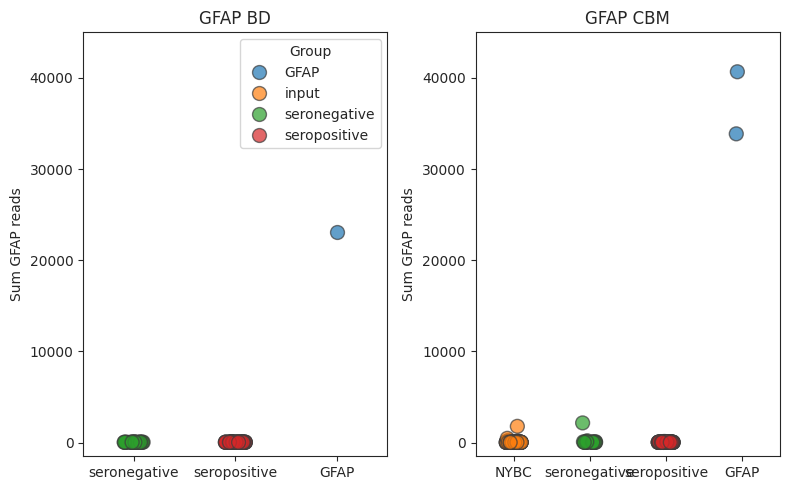

In [9]:
# plot sum of GFAP reads across samples
sns.set_style("ticks")
order_cbm = ['NYBC', 'seronegative', 'seropositive', 'GFAP']
order_bd = ['seronegative', 'seropositive', 'GFAP']

fig, axes = plt.subplots(1, 2, figsize=(8, 5))

ax1 = sns.stripplot(data=gfap_sum_bd, x="Sero", y="GFAP_sum", size = 10, hue='Group',
                   linewidth=1, color = None, ax=axes[0], order = order_bd, alpha = 0.7
                  )
ax1.set_ylim(-1500,45000)
ax1.set_xlabel("")
ax1.set_ylabel("Sum GFAP reads")
ax1.set_title("GFAP BD")

ax2 = sns.stripplot(data=gfap_sum_cbm, x="Group", y="GFAP_sum", size = 10, hue='Group',
                   linewidth=1, color = None, ax=axes[1], order = order_cbm, alpha = 0.7
                  )
ax2.set_ylim(-1500,45000)
ax2.set_xlabel("")
ax2.set_ylabel("Sum GFAP reads")
ax2.set_title("GFAP CBM")

plt.rcParams['axes.linewidth'] = .8

plt.tight_layout()

plt.savefig(fig_dir+'sfig_2.pdf', dpi=300 , bbox_inches="tight")
plt.show()

# SFig 4 -overlap of peptides between cohorts

In [10]:
# find the commonly enriched peptides across both specimen sets
## get list of overlapping peptide ids
overlapping_peptides = chagas_pept_cbm.index.intersection(chagas_pept_bd.index)

## subset each specimen set's peptides by the overlapping ids
cbm_subset = chagas_pept_cbm.loc[overlapping_peptides, ['gene', 'protein', 'refseq_id', 'seq']]
bd_subset = chagas_pept_bd.loc[overlapping_peptides, ['gene', 'protein', 'refseq_id', 'seq']]

## generate merged df that contains peptide info for overlapping ids
combined = pd.concat([cbm_subset, bd_subset]).drop_duplicates()

combined['seq'].nunique()

1370

In [11]:
# find how many unique proteins are represented in the overlapping peptide set
combined['refseq_id'].nunique()

961

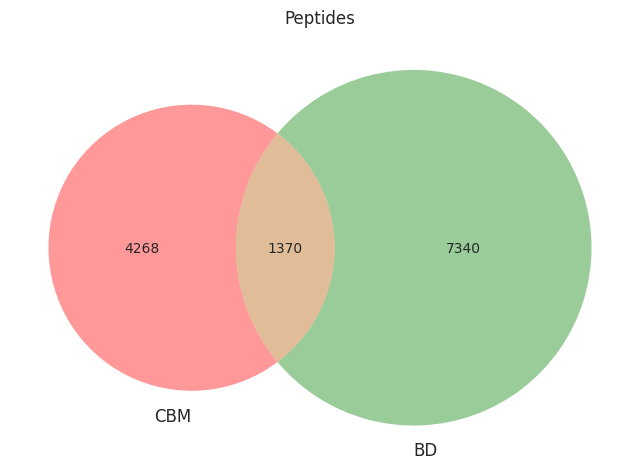

In [12]:
# create venn diagram of peptide overlap
plt.figure(figsize=(8, 8))
set_cbm = set(chagas_pept_cbm.index)
set_bd = set(chagas_pept_bd.index)

venn = venn2([set_cbm, set_bd], set_labels=('CBM', 'BD'))

plt.title('Peptides')
plt.savefig(fig_dir+'sfig_4.pdf',dpi=300,bbox_inches='tight')
plt.show()